<a href="https://colab.research.google.com/github/RyanHdez27/proyectoAnalisisDeDatos/blob/main/TrabajoBussinesAnalityc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 010 | train 0.0042 | val 0.0041


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Epoch 020 | train 0.0034 | val 0.0034
Epoch 030 | train 0.0030 | val 0.0030
Epoch 040 | train 0.0028 | val 0.0028
Epoch 050 | train 0.0027 | val 0.0026
Epoch 060 | train 0.0025 | val 0.0025
Epoch 070 | train 0.0025 | val 0.0024
Epoch 080 | train 0.0024 | val 0.0024
Epoch 090 | train 0.0024 | val 0.0023
Epoch 100 | train 0.0023 | val 0.0023
Epoch 110 | train 0.0023 | val 0.0022
Epoch 120 | train 0.0022 | val 0.0022
Epoch 130 | train 0.0022 | val 0.0021
Epoch 140 | train 0.0021 | val 0.0021
Epoch 150 | train 0.0021 | val 0.0021
Epoch 160 | train 0.0021 | val 0.0021
Epoch 170 | train 0.0021 | val 0.0020
Epoch 180 | train 0.0020 | val 0.0020
Epoch 190 | train 0.0020 | val 0.0020
Epoch 200 | train 0.0020 | val 0.0020


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


k=2 | silhouette=0.306


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


k=3 | silhouette=0.371


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


k=4 | silhouette=0.391


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


k=5 | silhouette=0.387


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


k=6 | silhouette=0.369
Mejor k=4 con silhouette=0.391


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


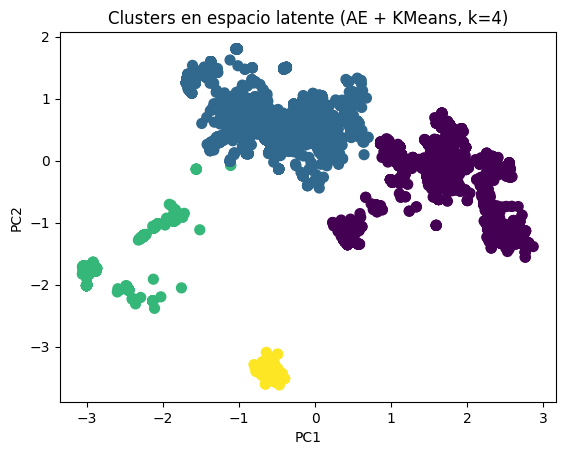


Perfil (AE + KMeans):
               Age  Years of Experience     Salary Gender    Education Level  \
Cluster_NN                                                                    
0           38.40                11.99  148279.43   Male                PhD   
1           31.92                 6.67  100917.85   Male  Bachelor's Degree   
2           27.93                 3.75   90631.71   Male         Bachelor's   
3           29.00                 4.18   85013.24   Male  Bachelor's Degree   

                      Job Title  Conteo  
Cluster_NN                               
0                Data Scientist    2258  
1             Software Engineer    3568  
2                  Data Analyst     640  
3           Front end Developer     238  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# 0) Cargar y preparar datos

df = pd.read_csv("Salary_Data.csv")

num_cols = ["Age", "Years of Experience", "Salary"]
cat_cols = ["Gender", "Education Level", "Job Title"]
num_cols = [c for c in num_cols if c in df.columns]
cat_cols = [c for c in cat_cols if c in df.columns]

X = df[num_cols + cat_cols].copy()

num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("num", num_tf, num_cols),
    ("cat", cat_tf, cat_cols)
])

X_pre = preprocess.fit_transform(X)
if hasattr(X_pre, "toarray"):
    X_pre = X_pre.toarray()


# 1) Definir Autoencoder

device = "cuda" if torch.cuda.is_available() else "cpu"
X_t = torch.tensor(X_pre, dtype=torch.float32)

class SimpleAE(nn.Module):
    def __init__(self, in_dim, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, in_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


# 2) Entrenamiento con early stopping sencillo

def train_autoencoder(X_tensor, latent_dim=8, epochs=200, batch_size=64, lr=1e-3, patience=15):
    in_dim = X_tensor.shape[1]
    dataset = TensorDataset(X_tensor)

    n_total = len(dataset)
    n_val = max(1, int(0.1 * n_total))
    n_train = n_total - n_val
    train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = SimpleAE(in_dim, latent_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    best_val = float("inf")
    wait = 0
    best_state = None

    for ep in range(1, epochs+1):
        # train
        model.train()
        total = 0.0
        for (xb,) in train_loader:
            xb = xb.to(device)
            opt.zero_grad()
            x_hat, _ = model(xb)
            loss = crit(x_hat, xb)
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
        train_loss = total / len(train_ds)

        # val
        model.eval()
        vtotal = 0.0
        with torch.no_grad():
            for (xb,) in val_loader:
                xb = xb.to(device)
                x_hat, _ = model(xb)
                vloss = crit(x_hat, xb)
                vtotal += vloss.item() * xb.size(0)
        val_loss = vtotal / len(val_ds)

        if ep % 10 == 0:
            print(f"Epoch {ep:03d} | train {train_loss:.4f} | val {val_loss:.4f}")

        # early stopping
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            wait = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping en epoch {ep} (mejor val {best_val:.4f})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

model = train_autoencoder(X_t, latent_dim=8, epochs=200, batch_size=64, lr=1e-3, patience=15)


# 3) Embedding latente

model.eval()
with torch.no_grad():
    Z = model.encoder(X_t.to(device)).cpu().numpy()


# 4) Elegir k con silhouette

def select_k_and_cluster(Z, k_min=2, k_max=6, random_state=42):
    best_k, best_sil, best_labels, best_km = None, -1, None, None
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = km.fit_predict(Z)
        s = silhouette_score(Z, labels)
        print(f"k={k} | silhouette={s:.3f}")
        if s > best_sil:
            best_k, best_sil, best_labels, best_km = k, s, labels, km
    return best_k, best_sil, best_labels, best_km

best_k, best_sil, labels_nn, km = select_k_and_cluster(Z, 2, 6)
print(f"Mejor k={best_k} con silhouette={best_sil:.3f}")

df["Cluster_NN"] = labels_nn


# 5) Visualización 2D (PCA)

Z2 = PCA(n_components=2, random_state=42).fit_transform(Z)
plt.figure()
plt.scatter(Z2[:, 0], Z2[:, 1], c=labels_nn, s=50)
plt.title(f"Clusters en espacio latente (AE + KMeans, k={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# 6) Perfilado por clúster

def moda_serie(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else np.nan

resumen_num = df.groupby("Cluster_NN")[num_cols].mean().round(2) if num_cols else pd.DataFrame()
resumen_cat = df.groupby("Cluster_NN")[cat_cols].agg(moda_serie) if cat_cols else pd.DataFrame()
perfil_nn = resumen_num.join(resumen_cat, how="outer")
perfil_nn["Conteo"] = df.groupby("Cluster_NN").size()
print("\nPerfil (AE + KMeans):\n", perfil_nn)

